Author-**Ayush Panda**

This project involves implementing Q-learning to determine dynamic parking prices for cars, exclusively intended for **Team Artemis** in the **Smart India Hackathon 2023** project.

**bold text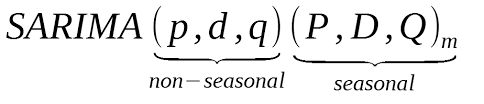**

Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from Workbook_Init import *



Data Download and Extraction

In [ ]:
import requests
import zipfile
import os


# URL for the dataset zip file
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00482/dataset.zip"
# Directory to save the dataset and extracted files
data_dir = "./data/"
# Path to save the zip file
zip_file_path = os.path.join(data_dir, "dataset.zip")
# Extracted dataset file path
extracted_dir = os.path.join(data_dir, "dataset")

# Create the data directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Download the dataset zip file
response = requests.get(url)
with open(zip_file_path, "wb") as zip_file:
    zip_file.write(response.content)

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(extracted_dir)

# Path to the dataset CSV file
dataset_csv_path = os.path.join(extracted_dir, "dataset.csv")


In [ ]:


# Read the dataset into a Pandas DataFrame
df_raw = pd.read_csv(dataset_csv_path)


**Data Cleaning and Preprocessing
**
This section includes various data cleaning and preprocessing steps such as converting date columns to datetime format, calculating occupancy percentages, filtering data, dropping duplicates, and handling missing values.

In [ ]:
df_head = df_raw.head(10)

In [ ]:
df_head

,SystemCodeNumber,Capacity,Occupancy,LastUpdated
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48
5,BHMBCCMKT01,577,177,2016-10-04 10:26:49
6,BHMBCCMKT01,577,219,2016-10-04 10:59:48
7,BHMBCCMKT01,577,247,2016-10-04 11:25:47
8,BHMBCCMKT01,577,259,2016-10-04 11:59:44
9,BHMBCCMKT01,577,266,2016-10-04 12:29:45


In [ ]:
df_raw.tail(10)

,SystemCodeNumber,Capacity,Occupancy,LastUpdated
35707,Shopping,1920,1424,2016-12-19 12:03:32
35708,Shopping,1920,1475,2016-12-19 12:30:32
35709,Shopping,1920,1510,2016-12-19 13:03:30
35710,Shopping,1920,1510,2016-12-19 13:30:35
35711,Shopping,1920,1521,2016-12-19 14:03:31
35712,Shopping,1920,1517,2016-12-19 14:30:33
35713,Shopping,1920,1487,2016-12-19 15:03:34
35714,Shopping,1920,1432,2016-12-19 15:29:33
35715,Shopping,1920,1321,2016-12-19 16:03:35
35716,Shopping,1920,1180,2016-12-19 16:30:35


In [ ]:
df_clean = df_raw.copy()
df_clean["LastUpdated"] = pd.to_datetime(df_clean["LastUpdated"])
df_clean["PercentOccupied"] = df_clean["Occupancy"] / df_clean["Capacity"]
df_clean["date"] = df_clean["LastUpdated"].dt.date
df_clean["dayofweek"] = df_clean["LastUpdated"].dt.dayofweek
df_clean["date_time_halfhour"] = df_clean["LastUpdated"].dt.round("30min")
df_clean["time"] = df_clean["date_time_halfhour"].dt.time

In [ ]:
# Filter out 7:30 measurements
df_clean = df_clean[df_clean["time"] > datetime.time(7, 30)]

# Drop duplicates
df_clean.drop_duplicates(inplace=True)


Visualization

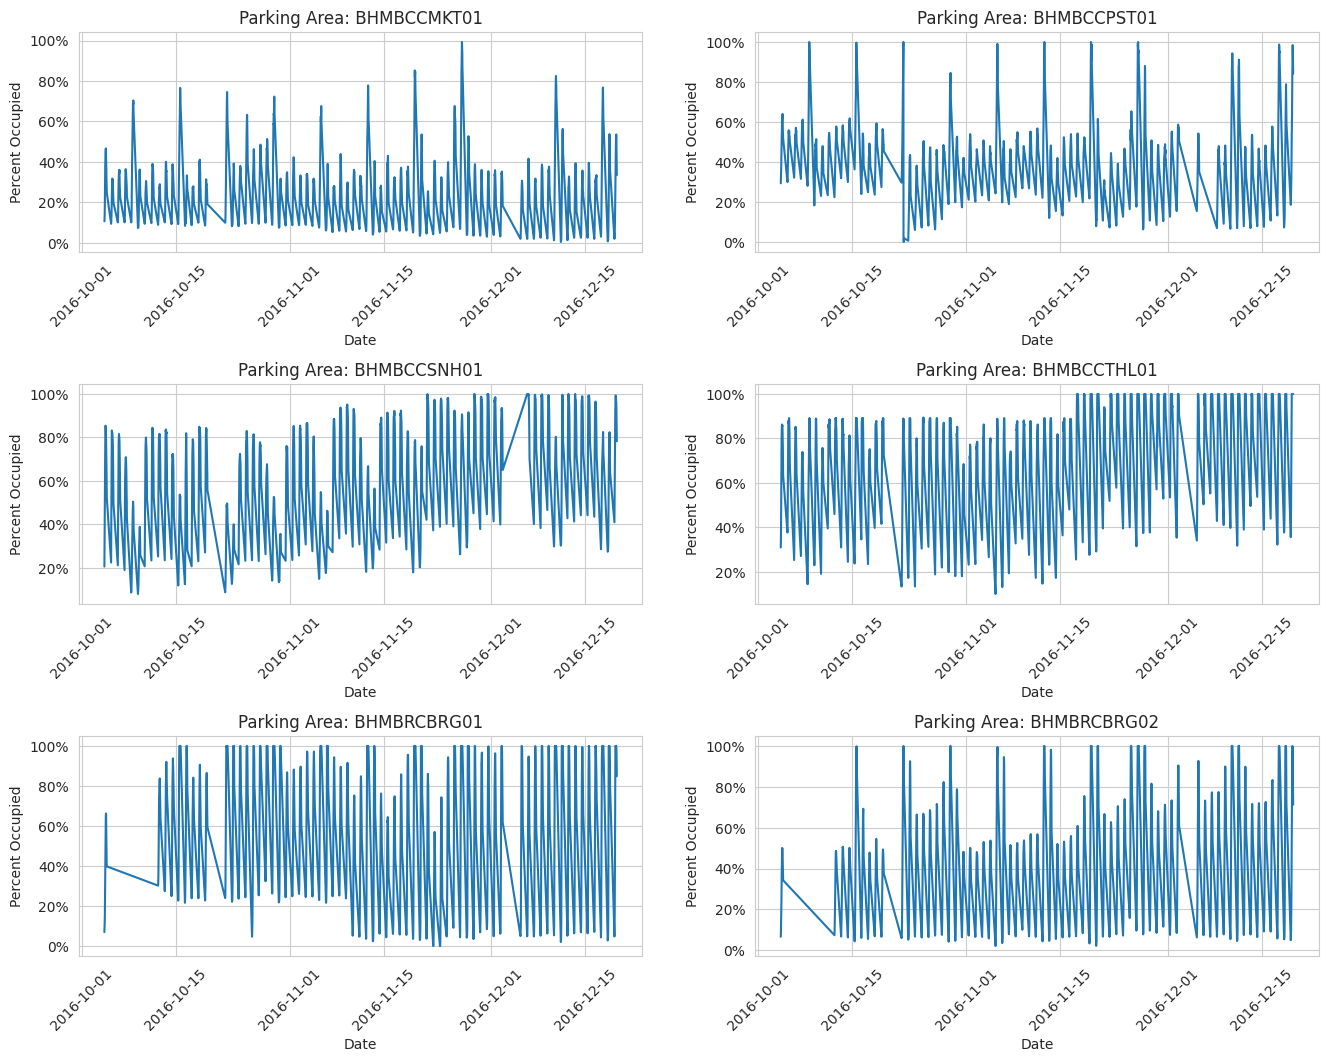

In [ ]:
# Limit Occupancy to the range of zero to Capacity
df_clean["Occupancy"] = df_clean[["Occupancy", "Capacity"]].apply(lambda x: max(0, min(x)), axis=1)
df_clean["PercentOccupied"] = df_clean["Occupancy"] / df_clean["Capacity"]

# Visualization
sample_plots_by_scn(df=df_clean, num_graphs=6, num_per_row=2)


**Data Aggregation
**
This section aggregates the cleaned data at a half-hourly level, calculating sums and counts for occupancy and capacity and deriving the percentage of occupancy.

In [ ]:
df_agg_dthh = df_clean.groupby('date_time_halfhour').agg({'Occupancy':['sum','count'], 'Capacity':['sum','count']})
df_agg_dthh['PercentOccupied'] = df_agg_dthh.Occupancy['sum'] / df_agg_dthh.Capacity['sum']
# Check for times when we dont have a big enough sample
df_agg_dthh[(df_agg_dthh.Occupancy['count']<20)|(df_agg_dthh.Capacity['sum']<25000)]



Occupancy       Capacity       PercentOccupied
                          sum count      sum count                
date_time_halfhour                                                
2016-10-28 08:00:00        10     1      450     1        0.022222
2016-12-13 13:30:00       663     1      720     1        0.920833

In [ ]:
df_agg_dthh.drop(columns=['Occupancy', 'Capacity'], inplace=True)
df_agg_dthh.drop([pd.Timestamp('2016-10-28 08:00:00'), pd.Timestamp('2016-12-13 13:30:00')], inplace=True)
df_agg_dthh.head()

,PercentOccupied
,
date_time_halfhour,
2016-10-04 08:00:00,0.201437
2016-10-04 08:30:00,0.247512
2016-10-04 09:00:00,0.315444
2016-10-04 09:30:00,0.382376
2016-10-04 10:00:00,0.438917


In [ ]:
df_agg_dthh.tail()

,PercentOccupied
,
date_time_halfhour,
2016-12-19 14:30:00,0.762891
2016-12-19 15:00:00,0.746696
2016-12-19 15:30:00,0.718909
2016-12-19 16:00:00,0.667912
2016-12-19 16:30:00,0.619624


In [ ]:
temp = df_agg_dthh.reset_index()
temp['date'] = temp.date_time_halfhour.dt.date
temp['time'] = temp.date_time_halfhour.dt.time
temp = temp.groupby('date').count()
temp = pd.DataFrame(temp, index=pd.date_range('2016-10-04', '2016-12-19')).fillna(0)
temp[temp.date_time_halfhour<18]


<ipython-input-33-662b4499a9f6>:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  temp = temp.groupby('date').count()


,date_time_halfhour,PercentOccupied,time
,,,
2016-10-20,0.0,0.0,0.0
2016-10-21,0.0,0.0,0.0
2016-10-28,17.0,17.0,17.0
2016-10-30,16.0,16.0,16.0
2016-11-18,17.0,17.0,17.0
2016-11-25,17.0,17.0,17.0
2016-12-03,0.0,0.0,0.0
2016-12-04,0.0,0.0,0.0
2016-12-13,17.0,17.0,17.0


**Data Imputation**

In [ ]:
def fill_with_week_prior(df, column, year, month, day, hour, minutes):
  df.loc[pd.to_datetime(datetime.datetime(year, month, day, hour, minutes)), column] = \
      df.loc[pd.to_datetime(datetime.datetime(year, month, day, hour, minutes) + timedelta(days=-7)), column].values[0]
# fill in missing Percent Occupied with prior week's value for same time

# Also fill in for the under-reported times noted above

df_agg_fillmissing = df_agg_dthh.copy()


# all day loop
for hour in range(8, 17):
  for half_hour in [0, 30]:
    fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 20, hour, half_hour)
    fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 21, hour, half_hour)
    fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 12, 3, hour, half_hour)
    fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 12, 4, hour, half_hour)

# fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 20, 8, 0)
# fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 21, 8, 0)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 30, 16, 0)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 30, 16, 30)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 11, 18, 9, 0)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 11, 25, 8, 30)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 12, 14, 11, 0)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 28, 8, 0)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 12, 13, 13, 30)

df_agg_fillmissing.sort_index(inplace=True)

temp = pd.Series(df_agg_fillmissing.index.date).value_counts()
temp[temp<18]

Series([], dtype: int64)

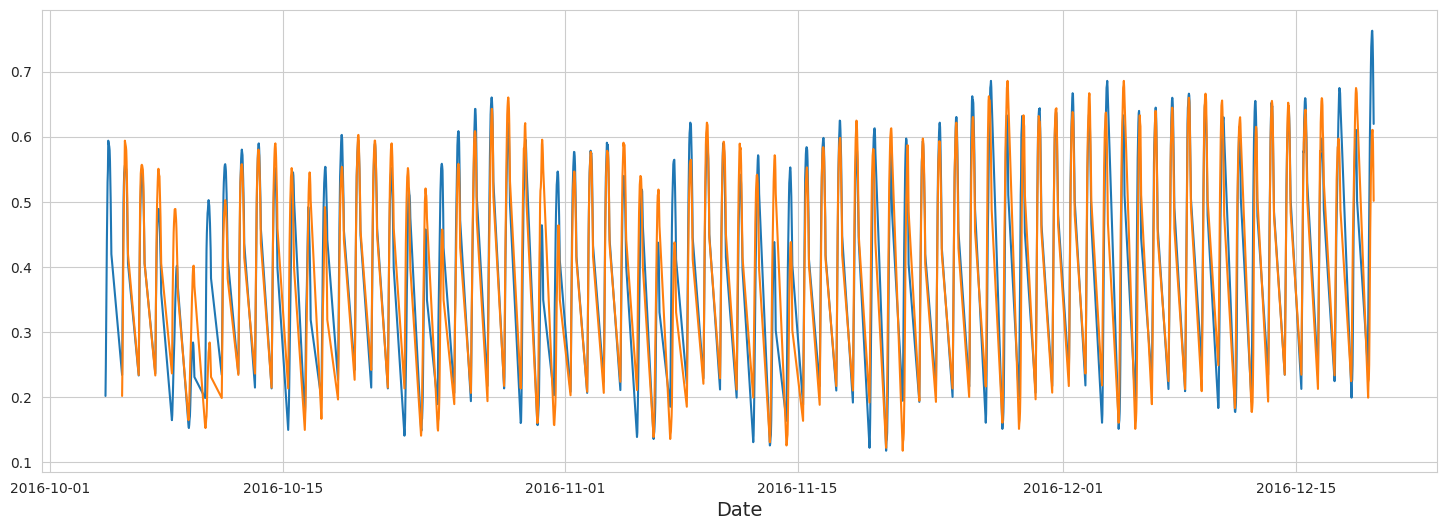

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(df_agg_fillmissing)
plt.plot(df_agg_fillmissing.shift(18))
plt.xlabel('Date', fontsize=14);

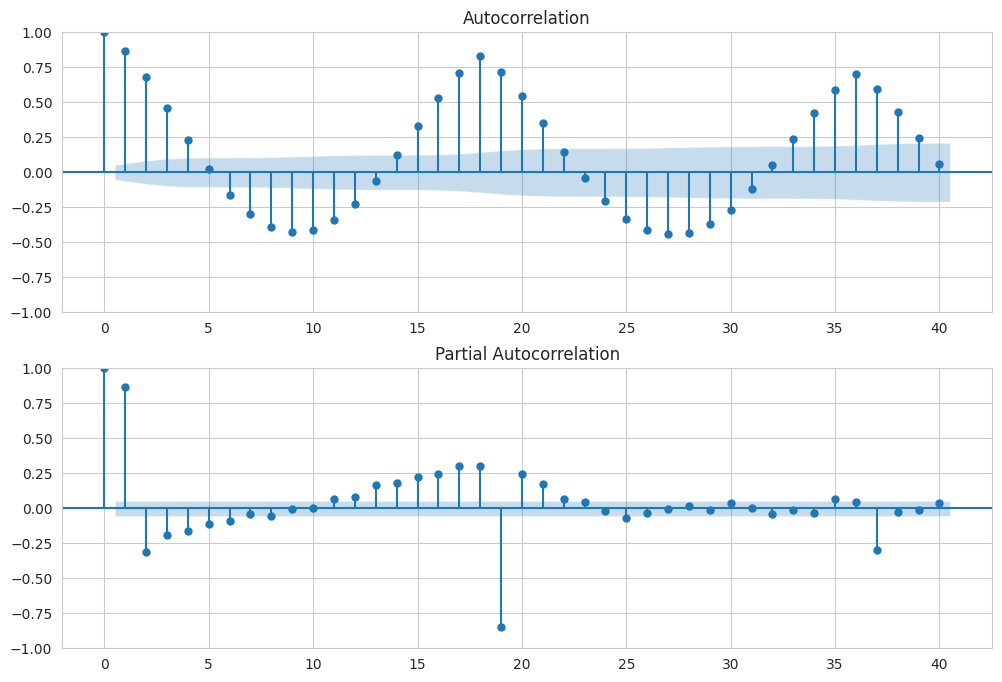

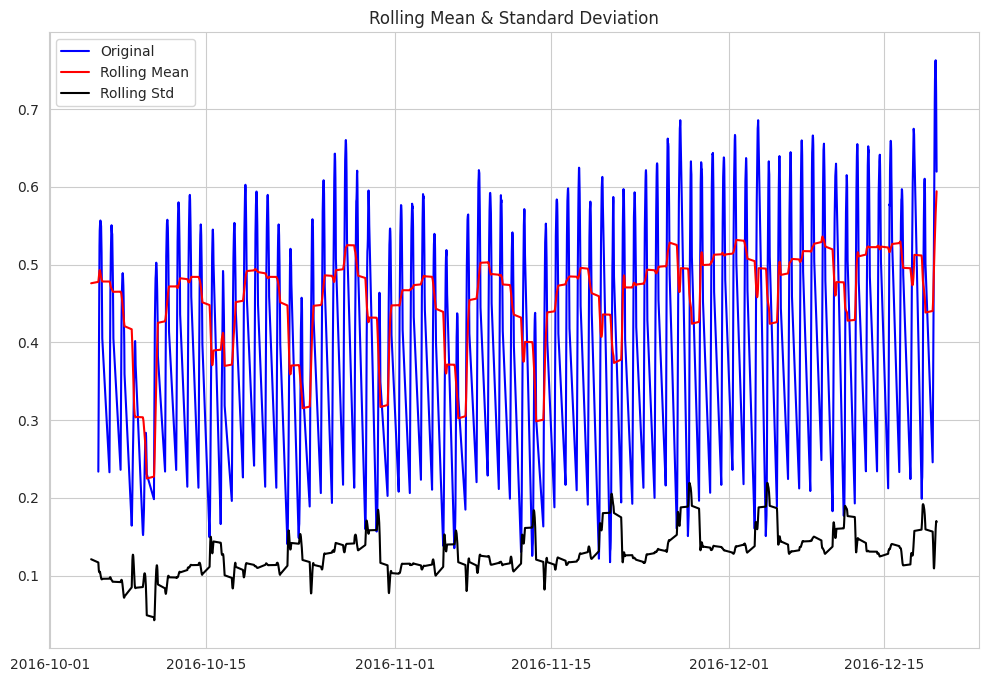

Results of Dickey-Fuller Test:
Test Statistic                   -4.028499
p-value                           0.001268
#Lags Used                       24.000000
Number of Observations Used    1361.000000
Critical Value (1%)              -3.435164
Critical Value (5%)              -2.863666
Critical Value (10%)             -2.567902
dtype: float64


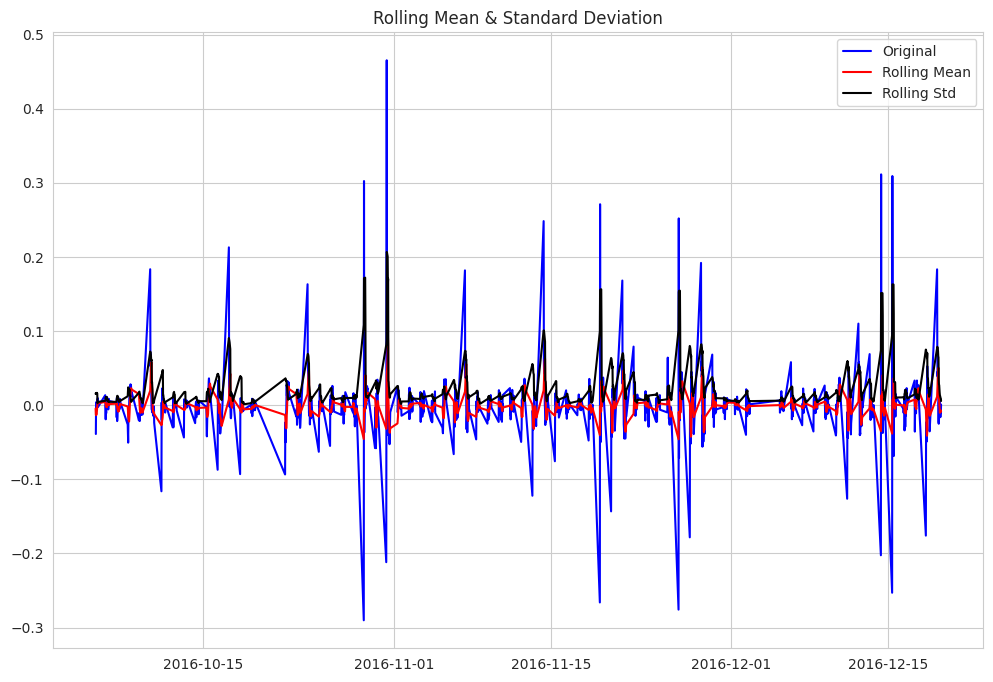

Results of Dickey-Fuller Test:
Test Statistic                -1.407532e+01
p-value                        2.891728e-26
#Lags Used                     1.900000e+01
Number of Observations Used    1.268000e+03
Critical Value (1%)           -3.435518e+00
Critical Value (5%)           -2.863822e+00
Critical Value (10%)          -2.567985e+00
dtype: float64


In [ ]:
subplots_acf_pacf(df_agg_fillmissing)
test_stationarity(df_agg_fillmissing.squeeze(), 18)
test_stationarity(df_agg_dthh.diff(18).diff().dropna().squeeze(), 7)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
print(tscv)


data_use = df_agg_fillmissing.reset_index()['PercentOccupied']

for train_index, test_index in tscv.split(data_use):
  train = data_use[train_index]
  test = data_use[test_index]


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


In [ ]:
train.index = df_agg_fillmissing.index[:len(train)]
train.tail()

date_time_halfhour
2016-12-06 16:00:00    0.505548
2016-12-06 16:30:00    0.458811
2016-12-07 08:00:00    0.212089
2016-12-07 08:30:00    0.256110
2016-12-07 09:00:00    0.310685
Name: PercentOccupied, dtype: float64

In [ ]:
test.index = df_agg_fillmissing.index[len(train):]
test.head()

date_time_halfhour
2016-12-07 09:30:00    0.368854
2016-12-07 10:00:00    0.438171
2016-12-07 10:30:00    0.494762
2016-12-07 11:00:00    0.557329
2016-12-07 11:30:00    0.589452
Name: PercentOccupied, dtype: float64

**ARIMA**
ARIMA is used to model the temporal patterns and dependencies in the occupancy data.
It helps in understanding how the current occupancy relates to its past values and forecasting future occupancy based on historical data.
Key Components:
Autoregressive (AR) Component (p):

Represents the relationship between the current observation and its past observations (lags).
The order 'p' (lag order) specifies how many past observations to consider.
Integrated (I) Component (d):

Deals with differencing the time series to make it stationary (constant mean and variance).
The order 'd' specifies the number of differencing operations required.
Moving Average (MA) Component (q):

Models the error of the model as a linear combination of error terms from past time points.
The order 'q' determines the size of the moving average window.
Use Cases in this Context:
Modeling occupancy patterns over time and understanding how occupancy at a given time relates to its past occupancy.
Forecasting future occupancy based on the occupancy history, aiding in resource planning and allocation.
Why Use ARIMA Here:
ARIMA is suitable for time series data analysis, capturing patterns and trends in the occupancy data.
It helps in making predictions about future occupancy trends based on historical occupancy patterns.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

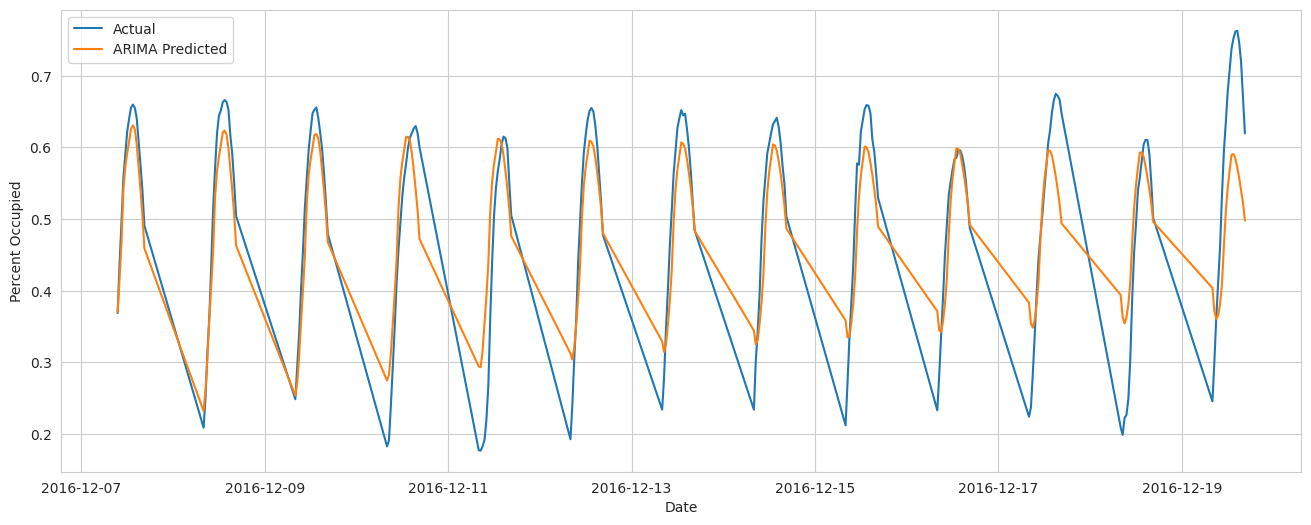

In [ ]:
# Train ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
arima_model = ARIMA(train, order=(18, 1, 0))
results_AR = arima_model.fit()

# Predict with ARIMA model
y_pred_AR = results_AR.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Visualization of ARIMA predictions
plt.figure(figsize=(16, 6))
plt.plot(test.index, test.values, label="Actual")
plt.plot(test.index, y_pred_AR, label="ARIMA Predicted")
plt.xlabel("Date")
plt.ylabel("Percent Occupied")
plt.legend()
plt.show()


**SARIMA**
SARIMA is an extension of ARIMA, considering seasonal patterns in the occupancy data.
It's used to model seasonal variations that may occur at regular intervals (e.g., daily or weekly patterns).
Key Components:
SARIMA includes additional seasonal autoregressive, differencing, and moving average components:
Seasonal Autoregressive (SAR) Component (P): Similar to AR component, but for seasonal lags.
Seasonal Integrated (SI) Component (D): Seasonal differencing.
Seasonal Moving Average (SMA) Component (Q): Similar to MA component, but for seasonal lags.
Additionally, it considers the seasonal period 's' (e.g., daily seasonality with s=24 for hourly data).
Use Cases in this Context:
Capturing and modeling seasonal variations in occupancy data, which is often seen in real-world scenarios (e.g., daily occupancy patterns).
Providing more accurate forecasts by considering both non-seasonal and seasonal components.
Why Use SARIMA Here:
The occupancy data may have seasonal patterns (e.g., weekdays vs. weekends), which SARIMA can model effectively.
By considering seasonality, SARIMA can improve the accuracy of occupancy forecasts, crucial for efficient resource utilization.
In summary, ARIMA is used to model temporal occupancy patterns and forecast future occupancy. SARIMA, an extension of ARIMA, is used to additionally capture seasonal variations in occupancy, enhancing the accuracy of predictions, especially when there are recurring patterns in the occupancy data.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


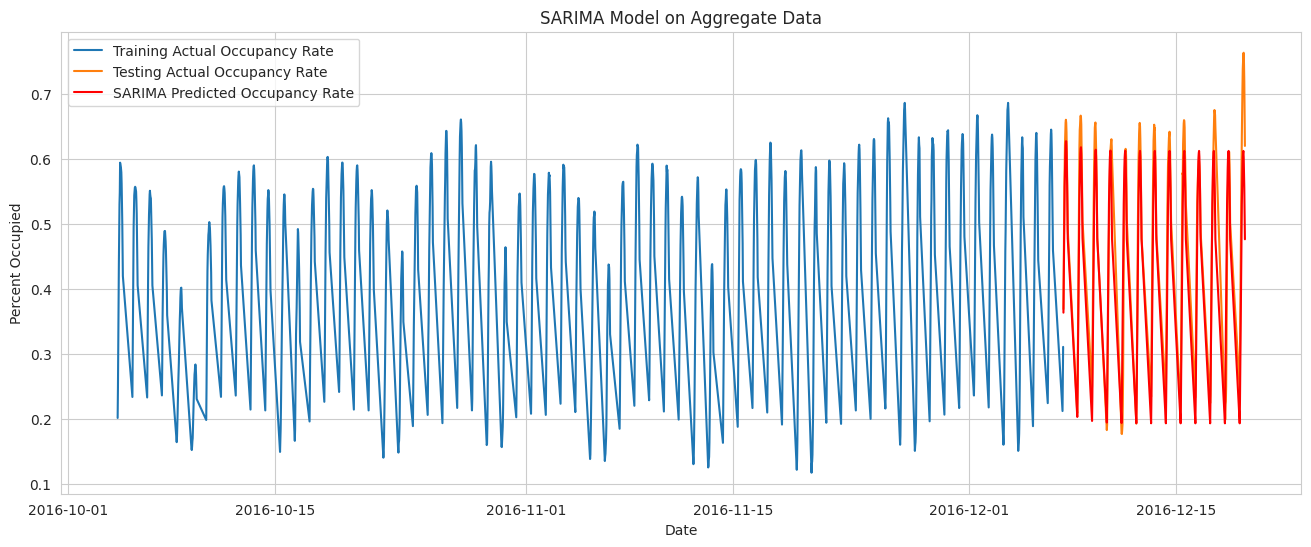

-----------------------------------------------------------------------------
SARIMA Model Metrics on Test Data
Explained Variance:
	 0.8579952590565098
MAE:
	 0.04905387785245523


In [ ]:
# Train SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define and fit SARIMA model
my_seasonal_order = (1, 1, 1, 18)
sarima_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=my_seasonal_order)
results_SAR = sarima_model.fit()

# Predict with SARIMA model
y_pred_sar = results_SAR.get_forecast(steps=len(test))

# Visualization of SARIMA predictions
plt.figure(figsize=(16, 6))
plt.title('SARIMA Model on Aggregate Data')
plt.plot(train, label='Training Actual Occupancy Rate')
plt.xlabel('Date')
plt.ylabel('Percent Occupied')
plt.plot(test.index, test.values, label='Testing Actual Occupancy Rate')
plt.plot(test.index, y_pred_sar.predicted_mean, color='red', label='SARIMA Predicted Occupancy Rate')
plt.legend()
plt.show()

# Print SARIMA model metrics
print('-' * 77)
print('SARIMA Model Metrics on Test Data')
print('=' * 77)

report_metrics(test.squeeze(), y_pred_sar.predicted_mean)


**Predicted Vs Actual**

In [ ]:

# Create a DataFrame for SARIMA model results
df_SAR_results = pd.DataFrame({
    'Date_Time': test.index,
    'Predicted': y_pred_sar.values,  # Accessing values directly from the Series
    'Actual': test.values
})


# Calculate the difference and absolute difference
df_SAR_results['Difference'] = df_SAR_results['Predicted'] - df_SAR_results['Actual']
df_SAR_results['Absolute_Diff'] = np.abs(df_SAR_results['Difference'])

# Sort by absolute difference
df_SAR_results = df_SAR_results.sort_values('Absolute_Diff', ascending=False)

print(df_SAR_results)



              Date_Time  Predicted    Actual  Difference  Absolute_Diff
74  2016-12-11 10:30:00   0.440250  0.266308    0.173942       0.173942
194 2016-12-17 16:30:00   0.476124  0.647990   -0.171867       0.171867
73  2016-12-11 10:00:00   0.388566  0.219690    0.168875       0.168875
227 2016-12-19 15:00:00   0.580703  0.746696   -0.165993       0.165993
228 2016-12-19 15:30:00   0.554743  0.718909   -0.164166       0.164166
..                  ...        ...       ...         ...            ...
104 2016-12-12 16:30:00   0.476146  0.477758   -0.001611       0.001611
63  2016-12-10 14:00:00   0.612503  0.613918   -0.001415       0.001415
87  2016-12-12 08:00:00   0.193315  0.192811    0.000504       0.000504
168 2016-12-16 12:30:00   0.583883  0.583848    0.000034       0.000034
175 2016-12-16 16:00:00   0.520058  0.520088   -0.000030       0.000030

[231 rows x 5 columns]


**MAE , MSE,  RMSE** *EVS*

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score


# Function to calculate and print metrics
def calculate_metrics(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    evs = explained_variance_score(actual, predicted)

    print(f'Metrics for {model_name}:')
    print('Mean Absolute Error (MAE):', mae)
    print('Mean Squared Error (MSE):', mse)
    print('Root Mean Squared Error (RMSE):', rmse)
    print('Explained Variance Score:', evs)
    print('='*50)

# Calculate metrics for ARIMA model
calculate_metrics(test.squeeze(), y_pred_AR.squeeze(), 'ARIMA')


# Get predicted values for SARIMA model
y_pred_sar = results_SAR.predict(start=len(train), end=len(train) + len(test) - 1)

# Calculate metrics for SARIMA model
calculate_metrics(test.squeeze(), y_pred_sar, 'SARIMA')



Metrics for ARIMA:
Mean Absolute Error (MAE): 0.05702988162732864
Mean Squared Error (MSE): 0.005300791543923467
Root Mean Squared Error (RMSE): 0.07280653503582948
Explained Variance Score: 0.7671252399465949
Metrics for SARIMA:
Mean Absolute Error (MAE): 0.04905387785245523
Mean Squared Error (MSE): 0.0038665885133708712
Root Mean Squared Error (RMSE): 0.0621818985989562
Explained Variance Score: 0.8579952590565098


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
df_SAR_results.head(100)

,Date_Time,Predicted,Actual,Difference,Absolute_Diff
74,2016-12-11 10:30:00,0.440250,0.266308,0.173942,0.173942
194,2016-12-17 16:30:00,0.476124,0.647990,-0.171867,0.171867
73,2016-12-11 10:00:00,0.388566,0.219690,0.168875,0.168875
227,2016-12-19 15:00:00,0.580703,0.746696,-0.165993,0.165993
228,2016-12-19 15:30:00,0.554743,0.718909,-0.164166,0.164166
...,...,...,...,...,...
43,2016-12-09 13:00:00,0.603615,0.652719,-0.049104,0.049104
106,2016-12-13 08:30:00,0.230080,0.279132,-0.049052,0.049052
145,2016-12-15 10:00:00,0.388251,0.435389,-0.047138,0.047138
98,2016-12-12 13:30:00,0.608865,0.655028,-0.046163,0.046163


Prediction at Desired Time

In [ ]:
# Assuming df_SAR_results is the DataFrame containing the predictions

# Replace 'desired_time' with the specific time you're interested in
desired_time = '2016-12-11 10:30:00'

# Filter the DataFrame for the specific time
prediction_at_desired_time = df_SAR_results[df_SAR_results['Date_Time'] == desired_time]

# Print the prediction at the desired time
print('Prediction at', desired_time)
print(prediction_at_desired_time)


Prediction at 2016-12-11 10:30:00
             Date_Time  Predicted    Actual  Difference  Absolute_Diff
74 2016-12-11 10:30:00    0.44025  0.266308    0.173942       0.173942


**Future Occupancy Rate Prediction**

The SARIMA model, once trained and validated on Historical Data, can be used to forecast future occupancy values for a specified time range or extract predictions at specific times. These predictions are crucial for decision-making, resource planning, and efficient management of the occupancy of a facility or space.






In [ ]:
# Forecast into the future for the year 2023
forecast_steps = (pd.to_datetime('2024-01-01') - df_agg_fillmissing.index[-1]).days // 30  # Monthly intervals

# Forecast using SARIMA model
forecast_2023 = results_SAR.forecast(steps=forecast_steps)

# Generate dates for the forecasted period (monthly intervals)
forecast_dates_2023 = pd.date_range(df_agg_fillmissing.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Create a DataFrame to store the forecasted predictions
forecast_df = pd.DataFrame({'Date': forecast_dates_2023, 'PredictedOccupancy': forecast_2023})
forecast_df.set_index('Date', inplace=True)

print(forecast_df)


                     PredictedOccupancy
Date                                   
2017-01-31 16:30:00            0.363316
2017-02-28 16:30:00            0.416184
2017-03-31 16:30:00            0.466012
2017-04-30 16:30:00            0.522543
2017-05-31 16:30:00            0.557100
...                                 ...
2023-09-30 16:30:00            0.608999
2023-10-31 16:30:00            0.612101
2023-11-30 16:30:00            0.602737
2023-12-31 16:30:00            0.580820
2024-01-31 16:30:00            0.554842

[85 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
